# Purpose
download wind nowcast from NOAA's GrADS Data Server 
and plot wind speed and vectors for timestamp closest 
to current time on a map

# Dependencies
python 3.6, datetime, pydap.client, numpy, xarray, pandas, os, cartopy, matplotlib.pyplot

# Creation Date
13 Aug 2018

# Author(s)
- `bjornb` <backeb@gmail.com> Bjorn Backeberg

# Log:
- 13 Aug 2018: `bjornb` - plot wind speed and directional streamlines on map using cartopy
- 03 Oct 2018: `bjornb` - add get gfs wind nowcast from NOAA's GrADS Data Server


In [1]:
# here we define some usefule functions
def nearest(items, pivot):
    """function returns the datetime in items which is the closest to the date pivot.
    Works on other types than datetime too out of the box, if the type supports comparison, 
    subtraction and abs, e.g.: numbers and vector types."""
    return min(items, key=lambda x: abs(x - pivot))

In [2]:
# here import all the necessary libraries
from datetime import datetime, timedelta
from pydap.client import open_url
import numpy as np
import xarray as xr
import pandas as pd
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt 

In [3]:
# here we fetch the latest GFS forcast data from NOAA's GrADS Data Server
ref_date = datetime.now()
url = "http://nomads.ncep.noaa.gov:9090/dods/gfs_0p25_1hr/gfs{date}/gfs_0p25_1hr_{hour}"

for z in ["18z", "12z", "06z", "00z"]:
    url_z = url.format(date=ref_date.strftime('%Y%m%d'), hour=z)
    try:
        dataset = open_url(url_z)
        print("got latest wind forcast, url is: " + url_z)
        break
    except:
        pass

got latest wind forcast, url is: http://nomads.ncep.noaa.gov:9090/dods/gfs_0p25_1hr/gfs20181005/gfs_0p25_1hr_00z


In [4]:
# here we set the domain we want download and plot
# domain = [lon-lower-left-corner, lon-upper-right-corner, lat-lower-left-corner, lat-upper-right-corner]
domain = [330, 359, 24, 34]

In [5]:
# here we subset and load region of interest
lon = dataset['lon'];
lat = dataset['lat']; 
lonIndx = np.squeeze(np.array(np.where((lon >= domain[0]) & (lon <= domain[1]))))
latIndx = np.squeeze(np.array(np.where((lat >= domain[2]) & (lat <= domain[3]))))
ugrd10m = dataset['ugrd10m'][:,slice(latIndx[0],latIndx[-1]),slice(lonIndx[0],lonIndx[-1])]
vgrd10m = dataset['vgrd10m'][:,slice(latIndx[0],latIndx[-1]),slice(lonIndx[0],lonIndx[-1])]
time = dataset['time']
timeUnits = time.attributes['units']
# del lon, lat, dataset, url_z # delete superfluous variables

In [6]:
# here we put everything into a xarray.Dataset - just makes life easier... probably a better way to do this
ds = xr.Dataset()
decode_time = xr.coding.times.decode_cf_datetime # need this guy when setting the time coord in xarray.Dataset
# here we write ugrd10m and vgrd10m to the xarray.Dataset
ds['ugrd10m'] = xr.DataArray(data=ugrd10m.data[0],
        name=ugrd10m.name, dims=ugrd10m.dimensions,
        coords={'time': decode_time(time[:], timeUnits), 'lat': ugrd10m.data[2], 'lon': ugrd10m.data[3]},
        attrs=ugrd10m.attributes)
ds['vgrd10m'] = xr.DataArray(data=vgrd10m.data[0],
        name=vgrd10m.name, dims=vgrd10m.dimensions,
        coords={'time': decode_time(time[:], timeUnits), 'lat': vgrd10m.data[2], 'lon': vgrd10m.data[3]},
        attrs=vgrd10m.attributes)

In [7]:
# here we write the xarray.Dataset to a netcdf file if we want to
# can skip this, but cool demo of how easy it is to write netcdf data using xarray is you set the ds up right
fname = "gfs_winds.nc"
try:
    os.remove(fname)
except OSError:
    pass
print("writing datastack to netcdf4 :: "+fname)
ds.to_netcdf(fname, 'w', 'NETCDF4')

writing datastack to netcdf4 :: gfs_winds.nc


In [8]:
# here we del some superfluous variables
# del decode_time, domain, open_url, ref_date, url, z

In [9]:
# here we get the timestamp closest to our current time, i.e. we want to plot the winds as predicted now
t0 = np.squeeze(np.where(pd.to_datetime(ds.time.data) == nearest(pd.to_datetime(ds.time.data), datetime.now())))

# here we define the variables to plot again... I know... better ways exist...
tm = ds.time.data[t0]
lon = ds.lon.data
lat = ds.lat.data
u = ds.ugrd10m.data[t0, :, :]
v = ds.vgrd10m.data[t0, :, :]

In [10]:
# here we calculate the wind speed magniture
uv = np.sqrt(u**2 + v**2)

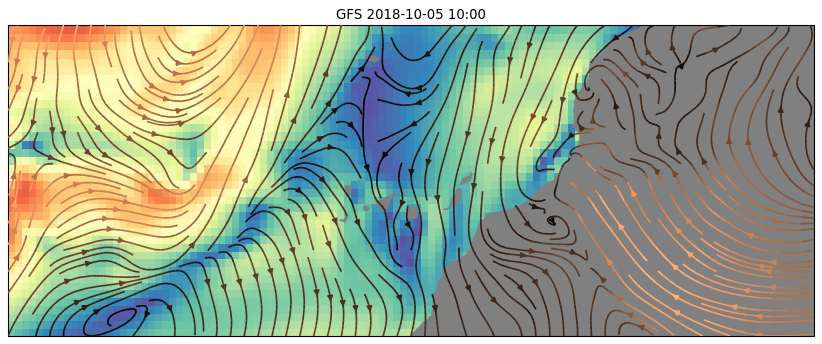

In [11]:
# here we plot the wind nowcast
fig = plt.figure(figsize = (13, 10), dpi = 80) 

# here we do all the plotting stuff
ax = plt.axes(projection=ccrs.Mercator(central_longitude = np.median(lon)))
# Set the map extent, making sure to specify the correct coordinate system
# for geographical coordinates:
ax.set_extent([ds.lon.data.min(), ds.lon.data.max(), ds.lat.data.min(), ds.lat.data.max()], crs=ccrs.PlateCarree())

ax.pcolormesh(lon, lat, uv, shading = 'gourand', cmap = plt.cm.Spectral_r, transform = ccrs.PlateCarree())
ax.streamplot(lon, lat, u, v, color = uv, 
              cmap = plt.cm.copper, 
              zorder = 10, 
              density = 2, 
              transform = ccrs.PlateCarree())

coastline = cfeature.GSHHSFeature(scale = 'intermediate', edgecolor = 'none', facecolor = 'grey')
ax.add_feature(coastline)

plt.title("GFS "+str((pd.to_datetime(tm)).strftime('%Y-%m-%d %H:%M')))

plt.show()